In [9]:
import os
import numpy 
from scipy import integrate, linalg 
from matplotlib import pyplot

# integrate plots into the notebook 
%matplotlib inline

In [10]:
Wing = numpy.genfromtxt('../AeroPython/lessons/resources/MainFoil_N=50.csv', delimiter =',')
Flap = numpy.genfromtxt('../AeroPython/lessons/resources/FlapFoil_N=50.csv', delimiter = ',')

In [11]:
Wing_x, Wing_y = Wing[:,0], Wing[:,1]
Flap_x, Flap_y = Flap[:,0], Flap[:,1]

N = numpy.size(Wing_x)-1

numpy.size(Wing_x) - 1,numpy.size(Flap_x) -1

(50, 50)

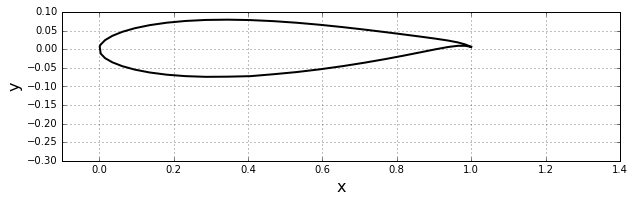

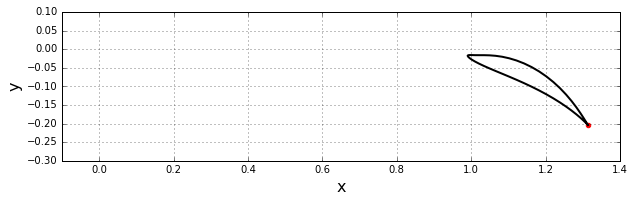

In [12]:
width =10
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(Wing_x,Wing_y,color='k', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.3,0.1);


width =10
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(Flap_x, Flap_y, color='k', linestyle='-', linewidth=2)

pyplot.scatter(Flap_x[0], Flap_y[0], color='R')

pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.3,0.1);

In [13]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [14]:
Wing_panels = numpy.empty(N, dtype = object)
Flap_panels = numpy.empty(N, dtype = object)
for i in range(N):
    Wing_panels[i] = Panel(Wing_x[i],Wing_y[i],Wing_x[i+1],Wing_y[i+1])
    Flap_panels[i] = Panel(Flap_x[i],Flap_y[i],Flap_x[i+1],Flap_y[i+1])

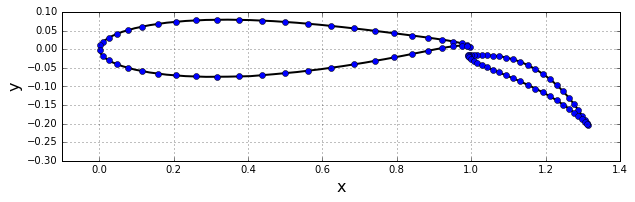

In [15]:
width= 10 
pyplot.figure(figsize=(width,width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(Wing_x,Wing_y,color='k', linestyle = '-', linewidth=2)
pyplot.plot(Flap_x,Flap_y,color='k', linestyle = '-', linewidth=2)
for i in range(N-1): 
    pyplot.plot(Wing_panels[i].xc, Wing_panels[i].yc, color = 'b', 
                    marker= 'o', markersize = 6)
    pyplot.plot(Flap_panels[i].xc, Flap_panels[i].yc, color = 'b', 
                    marker= 'o', markersize = 6)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.4)
pyplot.ylim(-0.3,0.1);

In [16]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians
        
        

def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]



def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A



def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A




def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0]+1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b


def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0]+1, A_source.shape[1]+1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A



def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size+1,dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b



def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size+1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]
        
        
        
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [17]:
freestream = Freestream(u_inf=1.0, alpha=0.0)

In [18]:
#Multi_panels = numpy.append(Wing_panels, Flap_panels)

In [19]:
A_source = source_contribution_normal(Wing_panels)
B_vortex = vortex_contribution_normal(Wing_panels)

In [20]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(Wing_panels, freestream)

In [21]:
# solve for singularity strengths
strengths = numpy.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(Wing_panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [22]:
compute_tangential_velocity(Wing_panels, freestream, gamma, A_source, B_vortex)
compute_pressure_coefficient(Wing_panels, freestream)

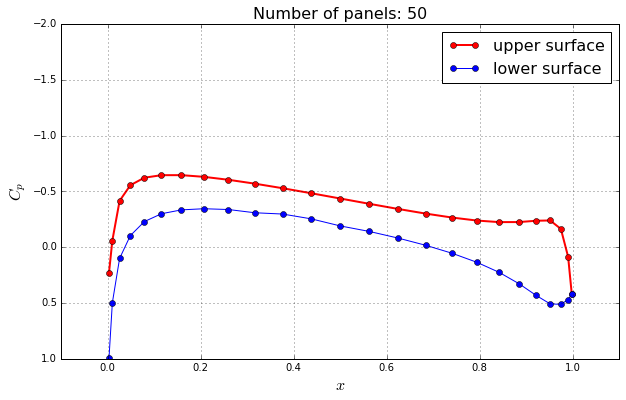

In [23]:
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in Wing_panels if panel.loc == 'upper'],
            [panel.cp for panel in Wing_panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in Wing_panels if panel.loc == 'lower'],
            [panel.cp for panel in Wing_panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(1.0, -2.0)
pyplot.title('Number of panels: {}'.format(Wing_panels.size), fontsize=16);

In [48]:
def get_velocity_source(strength, xs, ys, X, Y):
    """
    Returns the velocity field generated by a source/sink.
    
    Parameters
    ----------
    strength: float
        Strength of the source/sink.
    xs: float
        x-coordinate of the source (or sink).
    ys: float
        y-coordinate of the source (or sink).
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    u = strength/(2*numpy.pi)*(X-xs)/((X-xs)**2+(Y-ys)**2)
    v = strength/(2*numpy.pi)*(Y-ys)/((X-xs)**2+(Y-ys)**2)
    
    return u, v


def get_stream_function_source(strength, xs, ys, X, Y):
    """
    Returns the stream-function generated by a source/sink.
    
    Parameters
    ----------
    strength: float
        Strength of the source/sink.
    xs: float
        x-coordinate of the source (or sink).
    ys: float
        y-coordinate of the source (or sink).
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    psi: 2D Numpy array of floats
        The stream-function.
    """
    psi = strength/(2*numpy.pi)*numpy.arctan2((Y-ys), (X-xs))
    
    return psi




def get_velocity_vortex(strength, xv, yv, X, Y):
    """
    Returns the velocity field generated by a vortex.
    
    Parameters
    ----------
    strength: float
        Strength of the vortex.
    xv: float
        x-coordinate of the vortex.
    yv: float
        y-coordinate of the vortex.
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    u = + strength/(2*numpy.pi)*(Y-yv)/((X-xv)**2+(Y-yv)**2)
    v = - strength/(2*numpy.pi)*(X-xv)/((X-xv)**2+(Y-yv)**2)
    return u, v




def get_stream_function_vortex(strength, xv, yv, X, Y):
    """
    Returns the stream-function generated by a vortex.
    
    Parameters
    ----------
    strength: float
        Strength of the vortex.
    xv: float
        x-coordinate of the vortex.
    yv: float
        y-coordinate of the vortex.
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    psi: 2D Numpy array of floats
        The stream-function.
    """
    psi = strength/(4*numpy.pi)*numpy.log((X-xv)**2+(Y-yv)**2)
    
    return psi

In [38]:
space = 1

x_start, x_end = numpy.min(Wing_x) - space, numpy.max(Wing_x) + space
y_start, y_end = numpy.min(Wing_y) - space, numpy.max(Wing_y) + space

N = 50

x = numpy.linspace(x_start,x_end, N)
y = numpy.linspace(y_start,y_end, N)

X,Y = numpy.meshgrid(x,y)

numpy.max(Wing_x),numpy.min(Wing_x),numpy.max(Wing_y),numpy.min(Wing_y)

(1.0, 0.0014824999999999992, 0.079407094316243265, -0.074279529864981833)

In [49]:
u_source_sum=0
v_source_sum=0
psi_source_sum=0

u_vortex_sum=0
v_vortex_sum=0
psi_vortex_sum=0

a=0
for i in range(len(Wing_panels)):
    a = a +1
    u_source, v_source = get_velocity_source(Wing_panels[i].sigma, Wing_panels[i].xc, Wing_panels[i].yc, X, Y)
    u_vortex, v_vortex = get_velocity_vortex(gamma, Wing_panels[i].xc, Wing_panels[i].yc, X, Y)
    
    psi_source = get_stream_function_source(Wing_panels[i].sigma, Wing_panels[i].xc, Wing_panels[i].yc, X, Y)
    psi_vortex = get_stream_function_vortex(gamma, Wing_panels[i].xc, Wing_panels[i].yc, X, Y)
    
    u_source_sum = u_source_sum + u_source
    v_source_sum = v_source_sum + v_source
    
    u_vortex_sum = u_vortex_sum + u_vortex
    v_vortex_sum = v_vortex_sum + v_vortex
    
    psi_vortex_sum = psi_vortex_sum + psi_vortex
    


50

In [54]:
u = freestream.u_inf + u_source_sum + u_vortex_sum
v = freestream.u_inf + v_source_sum + v_vortex_sum
psi = freestream.u_inf*Y + psi_source_sum + psi_vortex_sum

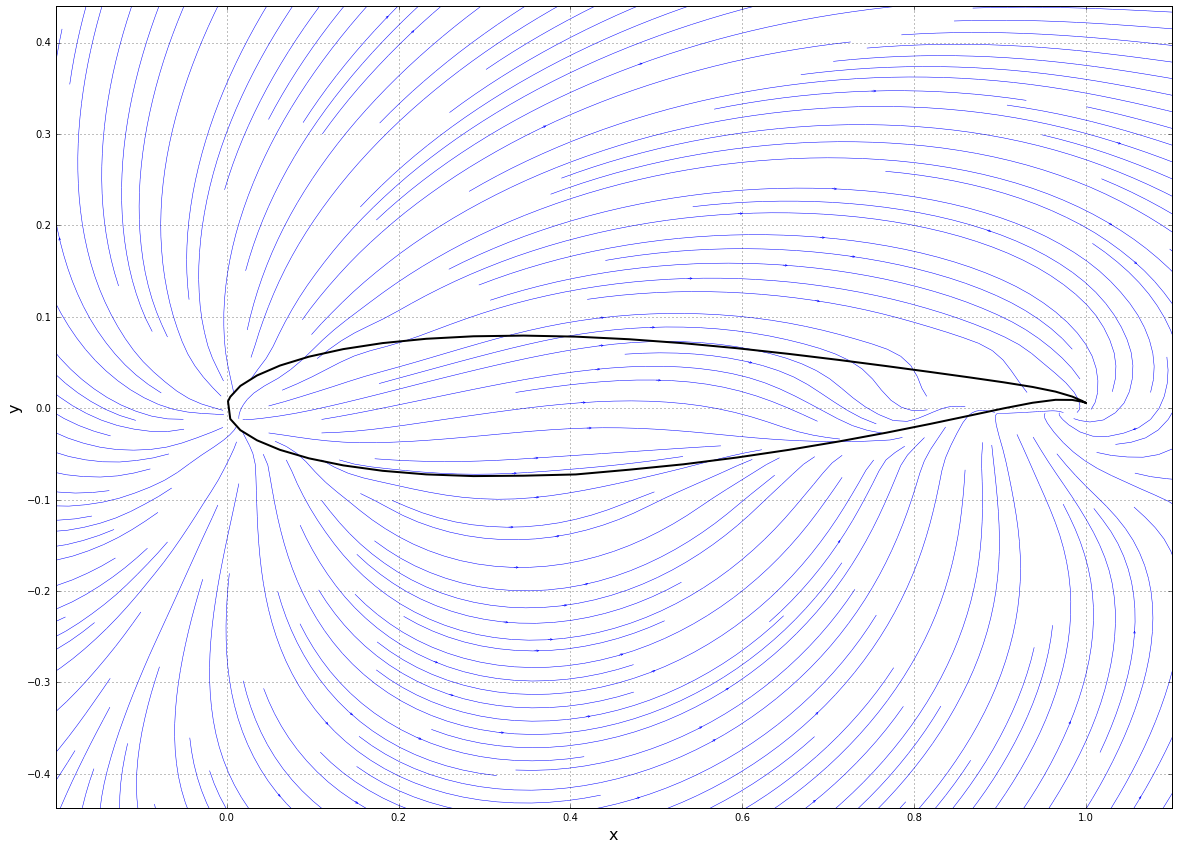

In [56]:
size = 20
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start/2+0.3, x_end/2+0.1)
pyplot.ylim(y_start/2+0.1, y_end/2-0.1)
pyplot.streamplot(X, Y, u, v, density=5, linewidth=0.5, arrowsize=0.5, arrowstyle='->')

pyplot.plot(Wing_x, Wing_y, color='k', linestyle='-', linewidth=2)